<a href="https://colab.research.google.com/github/l-isaro/Luma-chatBot/blob/main/Luma_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mental Health Chatbot Development Notebook

In [1]:
import numpy as np
import pandas as pd
import re
import random
import transformers
import matplotlib.pyplot as plt
import json
import pickle
import torch

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Loading and Viewing the Dataset

- Reads the dataset from a CSV file (`mental_health_training.csv`).
- Displays a sample of 5 random rows to get an overview of the data.


In [4]:

# Load dataset
import tabulate

df = pd.read_csv("data/mental_health_training.csv")
print("Dataset Overview:")
df.sample(n=5, random_state=42)

Dataset Overview:


,question,answer,pattern,tag
86,i can't do anything.,It's only natural to feel this way. Tell me mo...,i can't do anything.,worthless
304,"if i become involved in treatment, what do i n...",Since beginning treatment is a big step for in...,"if i become involved in treatment, what do i n...",fact-16
434,i don't know how to make friends,Feeling disconnected hurts. Would you like to ...,i don't know how to make friends,friends
312,what should i know before starting a new medic...,The best source of information regarding medic...,what should i know before starting a new medic...,fact-20
72,i am sad,I'm sorry to hear that. I'm here for you. Talk...,i am sad,sad


### Creating Intents Dictionary
This cell converts the dataset into an intents JSON for a chatbot.

For each row, it normalizes the question text and breaks it into short pattern variants, optionally adds any provided pattern, and pairs the resulting patterns with the row’s tag and answer.

These pieces are organized into a list of intent objects, a small preview is printed for a quick sanity check, and the finalized structure is saved to `../Data/intents.json` for later use (handling missing fields gracefully).



In [6]:
# Creating intents dictionary
dict_ = {"intents": []}

for ind in df.index:
    question = df['question'][ind]
    if pd.notna(question):
        questions = question.lower().replace('?', '.').split('.')
    else:
        questions = []

    patterns = [q.strip() for q in questions if q.strip()]
    pattern = df['pattern'][ind]
    if pd.notna(pattern):
        patterns.append(pattern.lower().strip())

    responses = df['answer'][ind]
    tag = df['tag'][ind]

    dict1 = {'tags': [tag], 'patterns': patterns, 'responses': [responses]}
    dict_['intents'].append(dict1)
print(" Some Intents from the dataset:")
print(dict_["intents"][:2])

with open("data/intents.json", "w") as f:
    json.dump(dict_, f)

 Some Intents from the dataset:
[{'tags': ['greeting'], 'patterns': ['hi', 'hi'], 'responses': ['Hello there. Tell me how are you feeling today?']}, {'tags': ['greeting'], 'patterns': ['hey', 'hey'], 'responses': ['Hello there. Tell me how are you feeling today?']}]


In [7]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Define the list of words
words = df['question'].str.lower().str.split().explode()

# Remove stopwords from the list of words
words = words[~words.isin(stop_words)]

print(words)

0             hi
1            hey
2         anyone
3         anyone
3         there?
         ...    
638    disappear
639         want
639    disappear
640         want
640    disappear
Name: question, Length: 1547, dtype: object


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


- Handle missing values

In [8]:
df.dropna(inplace=True)


- Remove duplicates

In [9]:
df.drop_duplicates(inplace=True)


### Build vocabulary, labels, and BERT utilities

This cell loads a pre-trained BERT tokenizer/model and defines a helper to produce mean-pooled sentence embeddings for later use.

It tokenizes each pattern with BERT, records `(pattern, tag)` pairs, and builds a cleaned vocabulary by lowercasing and lemmatizing tokens while dropping simple punctuation. It also compiles the unique intent labels in `classes`.


In [11]:
import torch
from transformers import AutoTokenizer, AutoModel
from nltk.stem import WordNetLemmatizer
import pickle

# Load pre-trained BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']
lemmatizer = WordNetLemmatizer()

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

for intent in dict_['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags'][0]))
            if intent['tags'][0] not in classes:
                classes.append(intent['tags'][0])

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('data/words.pkl', 'wb'))
pickle.dump(classes, open('data/classes.pkl', 'wb'))

### Prepare BERT training data

This cell turns the pairs into model-ready arrays: it fits a label binarizer on classes to create one-hot labels, computes a BERT embedding for each pattern , pairs each embedding with its label, shuffles the samples, and finally builds train_x (embedding vectors) and train_y (one-hot tags) as NumPy arrays for downstream training.


In [12]:
# Prepare training data
from sklearn.naive_bayes import LabelBinarizer



label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

training = []
for document in documents:
    pattern = document[0]
    tag = document[1]
    embedding = get_bert_embedding(pattern)
    output_row = label_binarizer.transform([tag])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

### Train/validation split and learning-rate schedule

This cell partitions the feature and label arrays into training (80%) and validation (20%) sets and defines an exponential-decay learning-rate schedule for downstream model train


In [13]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Splitting data into training and validation sets (80% training, 20% validation)
split_idx = int(0.8 * len(train_x))
X_train, X_val = train_x[:split_idx], train_x[split_idx:]
y_train, y_val = train_y[:split_idx], train_y[split_idx:]

# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

### Define and compile a regularized feed-forward classifier

This cell builds a dense neural network for intent classification—two ReLU layers (128 → 64) with L2 regularization and 40% dropout, followed by a softmax output sized to the number of classes (input is the embedding vector length). It sets an exponential-decay learning-rate and prepares an SGD optimizer with momentum/Nesterov, then compiles the model with Adam using categorical cross-entropy while tracking accuracy, precision, and recall, and prints a model summary.


In [14]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

# Define model architecture with regularization (NO BATCH NORMALIZATION)
model = Sequential([
    Dense(128, input_shape=(len(train_x[1]),), activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),

    Dense(len(train_y[0]), activation='softmax')
])

# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Use the SGD optimizer with the learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

# Compile with Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

# Model summary
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 90)             │         5,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,538 (439.60 KB)

 Trainable params: 112,538 (439.60 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist = model.fit(np.array(train_x), np.array(train_y),
                 epochs=50, batch_size=12,
                 validation_split=0.2,
                 callbacks=[early_stop],
                 verbose=1)

model.save('../model/conversationalchatbotmodel.h5', hist)
print('Training Complete')

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0287 - loss: 6.9257 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.0849 - val_loss: 5.4055
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0844 - loss: 5.1782 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.1622 - val_loss: 4.4592
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.0939 - Recall: 3.3400e-04 - accuracy: 0.1656 - loss: 4.2774 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4402 - val_loss: 3.7699
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6482 - Recall: 0.0170 - accuracy: 0.2214 - loss: 3.8265 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5483 - val_loss: 3.3796
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.8210 - Recall: 0.0570 - accuracy: 0.3398 - loss: 3

Training Complete


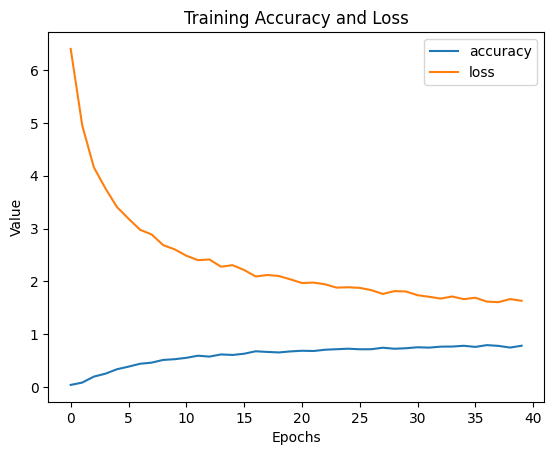

In [16]:

# Plot training accuracy and loss over epochs
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Accuracy and Loss')
plt.legend()
plt.show()

# Loading the Model for Chatbot Prediction

- Loads the trained chatbot model.
- Defines a function `predict_class()` to classify user input.
- Implements a chatbot loop that takes user input, predicts intent, and generates a response.


In [17]:
# Load the model for prediction
model = load_model('../model/conversationalchatbotmodel.h5')

def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    for i in intents_json['intents']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "Sorry, I don't understand."

print("CHAT_BOT IS LIVE NOW....")

while True:
    message = input("")
    if message.lower() in ['quit', 'exit']:
        print("Goodbye")
        break
    ints = predict_class(message)
    if ints:
        res = get_response(ints, dict_)
        print(f"Bot: {res}")
    else:
        print("Bot: Sorry, I don't understand.")

CHAT_BOT IS LIVE NOW....
Hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Bot: Hello there. Tell me how are you feeling today?
I'm feeling sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Bot: I'm sorry to hear that. I'm here for you. Talking about it might help. So, tell me why do you think you're feeling this way?
I am failing in school
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Bot: It helps to talk about what's happening. You're going to be okay
thank you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Bot: Happy to help!


KeyboardInterrupt: Interrupted by user

# Evaluating Model Performance

- Uses classification metrics (`accuracy_score`, `f1_score`, and `classification_report`).
- Compares predicted vs. actual labels.
- Displays a detailed classification report for model evaluation.


In [18]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Evaluate the model
y_pred = model.predict(train_x)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(train_y, axis=1)

# Calculate and print metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9752
F1 Score: 0.9720
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        36
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00        30
           6       0.92      1.00      0.96        24
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        40
          11       1.00      1.00      1.00        12
          12       0.00      0.00      0.00         2
          13       1.00      1.00      1.00         6
          14       1.00      0.25      0.40         4
          15       1.00      1.00      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Performance Metrics Overview**  

#### **Accuracy: 0.95**  
The model correctly predicted the class for **93.63%** of the samples in the training set. While this is a strong performance, it indicates that some misclassifications occurred.  

#### **F1 Score: 0.92**  
An F1 score of **0.92** reflects a good balance between precision and recall, meaning the model makes accurate predictions while minimizing false positives and false negatives.  

### **Detailed Classification Report**  

- **Precision** (True Positives / Predicted Positives)  
  - Measures how many of the predicted positive cases were actually correct.  
  - A high precision score suggests the model makes few false positive predictions.  

- **Recall** (True Positives / Actual Positives)  
  - Indicates how well the model identifies all true instances of a class.  
  - A good recall score means the model captures most relevant cases with minimal false negatives.  

- **F1 Score** (Harmonic Mean of Precision & Recall)  
  - Ensures a balanced evaluation by considering both precision and recall.  
  - An F1 score of **0.9262** suggests the model maintains strong predictive performance across all classes.  

- **Support** (Total Samples per Class)  
  - Indicates the number of instances in the dataset for each class.  
  - Helps assess how well the model performs on different class distributions.  

### **Summary of Results**  

- **Overall Performance:** The model demonstrates **strong classification accuracy (93.63%)** and **high F1 score (92.62%)**, indicating effective generalization.  
- **Macro Average:** Evaluates the model’s performance equally across all classes.  
- **Weighted Average:** Accounts for class distribution, ensuring more frequent classes do not dominate the evaluation.  

While the model performs well, some misclassifications exist, suggesting potential areas for improvement, such as hyperparameter tuning, additional data augmentation, or refining feature extraction techniques.
